/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


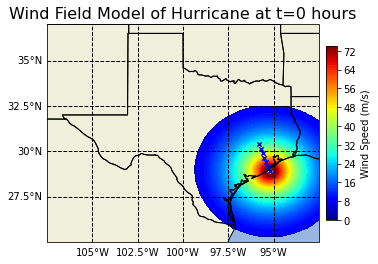

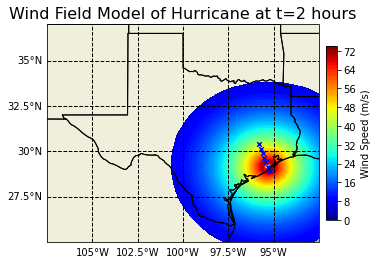

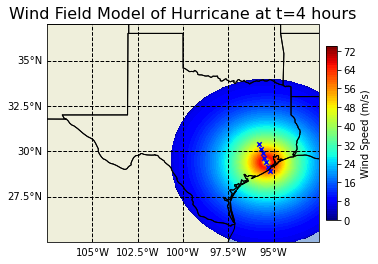

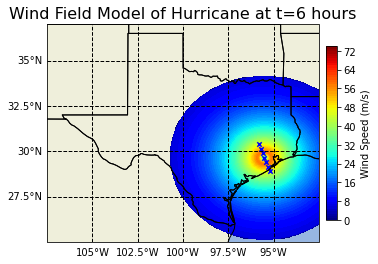

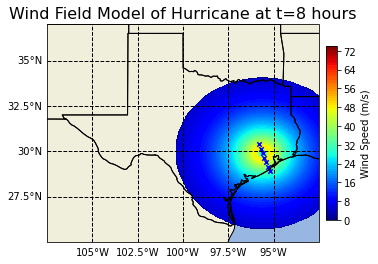

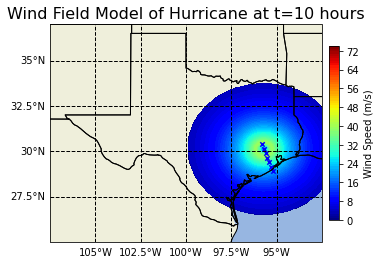

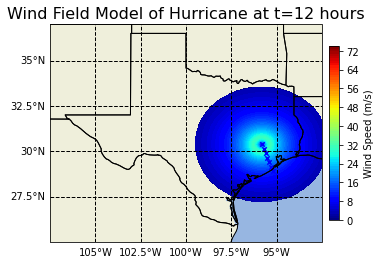

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import math

# INITIAL PARAMETERS #

# radius of maximum wind (km)
rmw = 28.5
# maximum sustained wind (m/s)
wm = 75
# radius of smallest wind (km)
rs_path = [400, 518, 507, 500, 459, 400, 351]
B = 10
K = 1.14
α = 0.04

Ξ = K * wm
Ψ = 1/(rmw)*math.log(K/(K-1))

# x and y coordinates of the eye of the hurricane
eyeX = -95.2
eyeY = 28.9
hurricanePath = [[-95.2, 28.9], [-95.3, 29.14], [-95.40, 29.39], [-95.51, 29.63], [-95.61, 29.88], [-95.71, 30.12], [-95.82, 30.37]]

# Calculating landfall pressure and Holland pressure parameter
P = math.sqrt((2.636 + 0.0394899 * eyeY - math.log(rmw))/0.0005086)
B_pressure = 1.38 + 0.00184*P - 0.00309*rmw

# Longitude: -107.5 to -92.5
# Latitude: 25.0 to 37.0
x1 = np.arange(-107.5,-92.5,0.05)
x2 = np.arange(25.0,37.0,0.05)
x1, x2 = np.meshgrid(x1, x2)

def landfall_wind_field(x1,x2):
  global rmw
  global wm
  global rs_path
  global B
  global K
  global Ξ
  global Ψ
  global eyeX
  global eyeY
  
  # revise x1 and x2 to account for the eye of the hurricane
  Olat = eyeY
  Olon = eyeX
  Dlat = x2
  Dlon = x1
  
  # Calculating distance to center
  d = 6371.  # km
  
  d_lat = np.radians(Dlat - Olat)
  d_lon = np.radians(Dlon - Olon)
  a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
       np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
       np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
  c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
  radius = d * c
  
  result = np.piecewise(radius, [(radius >= 0) & (radius < rmw), (radius >= rmw) & (radius <= rs_path[0]), radius > rs_path[0]], [lambda radius: (Ξ*(1 - np.exp(-1*Ψ*radius))), lambda radius: wm*np.exp(-1*(np.log(B)/(rs_path[0]-rmw))*(radius-rmw)),lambda radius: -1])

  return result

def plot_data(result, index):    
    global x1
    global x2
    global hurricanePath
    hours = index*2
    
    plt.figure(index)
    
    # Set the figure size, projection, and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-107.5,-92.5,25.0,37.0])
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black')
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    ax.coastlines(resolution="50m",linewidth=1)
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-107.5,-105.0,-102.5,-100.0,-97.5,-95.0,-92.5])
    gl.ylocator = mticker.FixedLocator([25,27.5,30.0,32.5,35.0,37.0])
    
    
    # Plot windspeed
    clevs = np.arange(0,75,1)
    plt.contourf(x1, x2, result, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    plt.title('Wind Field Model of Hurricane at t=' + str(hours) + ' hours', size=16)
    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    plt.scatter(*zip(*hurricanePath), s=20, marker='x', c='blue')
    cb.set_label('Wind Speed (m/s)',size=10,rotation=90,labelpad=5)
    cb.ax.tick_params(labelsize=10)


def dynamic_wind_field(index):
    global hurricanePath
    global α
    global P
    global B_pressure
    global rmw
    global wm
    global rs_path
    global B
    global K
    global Ξ
    global Ψ
    global x1
    global x2
    
    original_B = B_pressure
    original_P = P
    
    hours = index * 2
    
    P = P * math.exp(-1*α * hours)
    
    latitude = hurricanePath[index][1]
    rmw = math.exp(2.636 - 0.0005086*P*P + 0.0394899*latitude)
    B_pressure = 1.38 + 0.00184*P - 0.00309*rmw
    wm = wm*math.sqrt((B_pressure*P)/(original_B*original_P))
    rs = rs_path[index]
    
    Ξ = K * wm
    Ψ = 1/(rmw)*math.log(K/(K-1))
    
    Olat = hurricanePath[index][1]
    Olon = hurricanePath[index][0]
    Dlat = x2
    Dlon = x1
    
    # Calculating distance to center
    d = 6371.  # km
    
    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    radius = d * c
    
    result = np.piecewise(radius, [(radius >= 0) & (radius < rmw), (radius >= rmw) & (radius <= rs), radius > rs], [lambda radius: (Ξ*(1 - np.exp(-1*Ψ*radius))), lambda radius: wm*np.exp(-1*(np.log(B)/(rs-rmw))*(radius-rmw)),lambda radius: -1])
  
    return result


# PLOTTING THE DATA #
result = landfall_wind_field(x1,x2)
plot_data(result, 0)

result_1 = dynamic_wind_field(1)
plot_data(result_1, 1)

result_2 = dynamic_wind_field(2)
plot_data(result_2, 2)

result_3 = dynamic_wind_field(3)
plot_data(result_3, 3)

result_4 = dynamic_wind_field(4)
plot_data(result_4, 4)

result_5 = dynamic_wind_field(5)
plot_data(result_5, 5)

result_6 = dynamic_wind_field(6)
plot_data(result_6, 6)

In [10]:
pip install shapely --no-binary shapely

In [9]:
pip install cartopy